# Download

In [1]:
WORKING_ENV = 'LOCAL' # Can be LABS, COLAB or PAPERSPACE
assert WORKING_ENV in ['LABS', 'COLAB', 'LOCAL']

import sys
if WORKING_ENV == 'COLAB':
  from google.colab import drive
  drive.mount('/content/drive/')
  !pip install medmnist
  !pip install torch
  !pip install gputil
  !pip install psutil
  !pip install humanize
  ROOT = "/content/drive/MyDrive/ColabNotebooks/med-contrastive-project/"
  sys.path.append(ROOT + "./moco/")
  !nvidia-smi
elif WORKING_ENV == 'LABS':
  ROOT = "/vol/bitbucket/sx119/Contrastive-Medical-Image-Classification/"
else:
  ROOT = "/Users/xushitong/Contrastive-Medical-Image-Classification/"

# Import

In [6]:
import medmnist

import argparse
import builtins
import math
import os
import random
import shutil
import time
import tqdm
import warnings

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
# import torch.distributed as dist
import torch.optim
import torch.multiprocessing as mp
import torch.utils.data
# import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

import loader
import builder

In [3]:
# Import packages
import os,sys,humanize,psutil,GPUtil

# Define function
def mem_report():
  print("CPU RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ))
  
  GPUs = GPUtil.getGPUs()
  for i, gpu in enumerate(GPUs):
    print('GPU {:d} ... Mem Free: {:.0f}MB / {:.0f}MB | Utilization {:3.0f}%'.format(i, gpu.memoryFree, gpu.memoryTotal, gpu.memoryUtil*100))

mem_report()

CPU RAM Free: 12.5 GB
GPU 0 ... Mem Free: 15109MB / 15360MB | Utilization   0%


# Hyperparameters

In [8]:
EPOCH_NUM = 20
BATCH_SIZE = 128
LEARNING_RATE = 0.03
MOMENTUM = 0.9
LOSS_TYPE = "self"
# LOSS_TYPE = "cate-ce"
# LOSS_TYPE = "binary-ce"
TRAIN_SET_RATIO = 0.9
MOCO_V2 = True

trial_name = f"epochs{EPOCH_NUM}_batch{BATCH_SIZE}_lr{LEARNING_RATE}_momentum{MOMENTUM}_loss-type{LOSS_TYPE}_V2{MOCO_V2}"
arg_command = \
f"--epochs_{EPOCH_NUM}_-b_{BATCH_SIZE}_--lr_{LEARNING_RATE}_--momentum_{MOMENTUM}_--print-freq_100\
_--loss-type_{LOSS_TYPE}_{'' if WORKING_ENV == 'LOCAL' else '--gpu_0_'}{'--mlp_--aug-plus_--cos_' if MOCO_V2 else ''}{ROOT}./datasets".split("_")

print(f"Running command {arg_command}")

Running command ['--epochs', '20', '-b', '128', '--lr', '0.03', '--momentum', '0.9', '--print-freq', '100', '--loss-type', 'self', '--mlp', '--aug-plus', '--cos', '/Users/xushitong/Contrastive-Medical-Image-Classification/./datasets']


In [9]:
#!/usr/bin/env python
# Copyright (c) Facebook, Inc. and its affiliates. All Rights Reserved

model_names = sorted(name for name in models.__dict__
    if name.islower() and not name.startswith("__")
    and callable(models.__dict__[name]))

parser = argparse.ArgumentParser(description='PyTorch ImageNet Training')
parser.add_argument('data', metavar='DIR',
                    help='path to dataset')
parser.add_argument('-a', '--arch', metavar='ARCH', default='resnet50',
                    choices=model_names,
                    help='model architecture: ' +
                        ' | '.join(model_names) +
                        ' (default: resnet50)')
# parser.add_argument('-j', '--workers', default=32, type=int, metavar='N',
#                     help='number of data loading workers (default: 32)')
parser.add_argument('--epochs', default=200, type=int, metavar='N',
                    help='number of total epochs to run')
parser.add_argument('--start-epoch', default=0, type=int, metavar='N',
                    help='manual epoch number (useful on restarts)')
parser.add_argument('-b', '--batch-size', default=256, type=int,
                    metavar='N',
                    help='mini-batch size (default: 256), this is the total '
                         'batch size of all GPUs on the current node when '
                         'using Data Parallel or Distributed Data Parallel')
parser.add_argument('--lr', '--learning-rate', default=0.03, type=float,
                    metavar='LR', help='initial learning rate', dest='lr')
parser.add_argument('--schedule', default=[120, 160], nargs='*', type=int,
                    help='learning rate schedule (when to drop lr by 10x)')
parser.add_argument('--momentum', default=0.9, type=float, metavar='M',
                    help='momentum of SGD solver')
parser.add_argument('--wd', '--weight-decay', default=1e-4, type=float,
                    metavar='W', help='weight decay (default: 1e-4)',
                    dest='weight_decay')
parser.add_argument('-p', '--print-freq', default=10, type=int,
                    metavar='N', help='print frequency (default: 10)')
parser.add_argument('--resume', default='', type=str, metavar='PATH',
                    help='path to latest checkpoint (default: none)')
# parser.add_argument('--world-size', default=-1, type=int,
#                     help='number of nodes for distributed training')
# parser.add_argument('--rank', default=-1, type=int,
#                     help='node rank for distributed training')
# parser.add_argument('--dist-url', default='tcp://224.66.41.62:23456', type=str,
#                     help='url used to set up distributed training')
# parser.add_argument('--dist-backend', default='nccl', type=str,
#                     help='distributed backend')
parser.add_argument('--seed', default=None, type=int,
                    help='seed for initializing training. ')
parser.add_argument('--gpu', default=None, type=int,
                    help='GPU id to use.')
# parser.add_argument('--multiprocessing-distributed', action='store_true',
#                     help='Use multi-processing distributed training to launch '
#                          'N processes per node, which has N GPUs. This is the '
#                          'fastest way to use PyTorch for either single node or '
#                          'multi node data parallel training')
# new argument proposed for medical image classification
parser.add_argument('-lt', '--loss-type', default="binary-ce", type=str,
                    help='self if positive pairs are from the same image'
                    'cate-ce if categorical cross entropy loss is used for positive pairs from the same category'
                    'binary-ce if binary cross entropy loss is used for positive pairs from the same category')

# moco specific configs:
parser.add_argument('--moco-dim', default=128, type=int,
                    help='feature dimension (default: 128)')
parser.add_argument('--moco-k', default=65536, type=int,
                    help='queue size; number of negative keys (default: 65536)')
parser.add_argument('--moco-m', default=0.999, type=float,
                    help='moco momentum of updating key encoder (default: 0.999)')
parser.add_argument('--moco-t', default=0.07, type=float,
                    help='softmax temperature (default: 0.07)')

# options for moco v2
parser.add_argument('--mlp', action='store_true',
                    help='use mlp head')
parser.add_argument('--aug-plus', action='store_true',
                    help='use moco v2 data augmentation')
parser.add_argument('--cos', action='store_true',
                    help='use cosine lr schedule')

_StoreTrueAction(option_strings=['--cos'], dest='cos', nargs=0, const=True, default=False, type=None, choices=None, required=False, help='use cosine lr schedule', metavar=None)

In [10]:
args = parser.parse_args(arg_command)

if args.seed is not None:
    random.seed(args.seed)
    torch.manual_seed(args.seed)
    cudnn.deterministic = True
    warnings.warn('You have chosen to seed training. '
                  'This will turn on the CUDNN deterministic setting, '
                  'which can slow down your training considerably! '
                  'You may see unexpected behavior when restarting '
                  'from checkpoints.')

# Training helper functions

In [19]:
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, file, num_batches, meters, prefix=""):
        self.file = file
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        self.file.write('\t'.join(entries) + "\n")

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'


def adjust_learning_rate(optimizer, epoch, args):
    """Decay the learning rate based on schedule"""
    lr = args.lr
    if args.cos:  # cosine lr schedule
        lr *= 0.5 * (1. + math.cos(math.pi * epoch / args.epochs))
    else:  # stepwise lr schedule
        for milestone in args.schedule:
            lr *= 0.1 if epoch >= milestone else 1.
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


def accuracy(output, target, topk=(1,)):
    """
    NOT IN USE
    Computes the accuracy over the k top predictions for the specified values of k
    """
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res


def update_accuracy_meters(losses, top1, top5, output, target, loss, step_size):
    """
    NOT IN USE
    Update loss, top1, top5 metrics for either train or validation

    Inputs:
      - step_size: parameter n for loss/top1/top5 meters
    """
    # acc1/acc5 are (K+1)-way contrast classifier accuracy
    # measure accuracy and record loss
    acc1, acc5 = accuracy(output, target, topk=(1, 5))
    losses.update(loss.item(), step_size)
    top1.update(acc1[0], step_size)
    top5.update(acc5[0], step_size)


ce_loss_ = nn.CrossEntropyLoss(reduction="mean") # take softmax, sum CrossEntropy per sample, take mean
binary_loss_ = nn.BCEWithLogitsLoss(reduction="mean") # take mean of per sample per pair binary Cross Entropy
if args.gpu is not None:
  ce_loss_ = ce_loss_.cuda(args.gpu)
  binary_loss_ = binary_loss_.cuda(args.gpu)
def multi_label_loss(prediction, target):
    """
    NOT IN USE
    Loss to handle multi-label classification when multiple positive image pairs exist.
    loss function used defined in args.loss_type
    
    Inputs: 
      - pretiction: shape: [bathc_size, 1 + k]
      - target: [batch_size] if self, otherwise [batch_size, 1 + K]
      
    Outputs:
      - scalar loss value for back propagate
    """
    
    if args.loss_type == "binary-ce":
      loss = binary_loss_(prediction, target).sum(dim=-1)
    elif args.loss_type in ["cate-ce", "self"]:
      loss = ce_loss_(prediction, target)
    
    return loss.mean()

# Dataset

In [20]:
# Data loading code
# traindir = os.path.join(args.data, 'train')
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])
if args.aug_plus:
    # MoCo v2's aug: similar to SimCLR https://arxiv.org/abs/2002.05709
    augmentation = [
        transforms.RandomResizedCrop(224, scale=(0.2, 1.)),
        transforms.RandomApply([
            transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)  # not strengthened
        ], p=0.8),
        transforms.RandomGrayscale(p=0.2),
        transforms.RandomApply([loader.GaussianBlur([.1, 2.])], p=0.5),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ]
else:
    # MoCo v1's aug: the same as InstDisc https://arxiv.org/abs/1805.01978
    augmentation = [
        transforms.RandomResizedCrop(224, scale=(0.2, 1.)),
        transforms.RandomGrayscale(p=0.2),
        transforms.ColorJitter(0.4, 0.4, 0.4, 0.4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ]

train_dataset = medmnist.PathMNIST("train", download=False, root=args.data, 
                                   transform=loader.TwoCropsTransform(transforms.Compose(augmentation)))
val_dataset = medmnist.PathMNIST("val", download=False, root=args.data, 
                                   transform=loader.TwoCropsTransform(transforms.Compose(augmentation)))

pretrain_len = int(len(train_dataset) * TRAIN_SET_RATIO)
pretrain_set, pretrain_val_set = torch.utils.data.random_split(train_dataset, [pretrain_len, len(train_dataset) - pretrain_len])

pretrain_loader = torch.utils.data.DataLoader(
    pretrain_set, batch_size=args.batch_size, shuffle=True, 
    pin_memory=True, drop_last=True)
pretrain_val_loader = torch.utils.data.DataLoader(
    pretrain_val_set, batch_size=2 * args.batch_size, shuffle=False, 
    pin_memory=True, drop_last=True)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=2 * args.batch_size, shuffle=False, 
    pin_memory=True, drop_last=True)

print(f"pretrain size: {len(pretrain_set)}\npretrain validation size: {len(pretrain_val_set)}\nvalidation size, {len(val_dataset)}")


pretrain size: 80996
pretrain validation size: 9000
validation size, 10004


# Train

In [21]:
if WORKING_ENV == 'LABS':
  summary = open(trial_name + ".txt", "a")
else:
  summary = sys.stdout

print("=> creating model '{}'".format(args.arch))
model = builder.MoCo(
    models.__dict__[args.arch],
    args.moco_dim, args.moco_k, args.moco_m, args.moco_t, args.mlp)
# print(model)

if args.gpu is not None:
  torch.cuda.set_device(args.gpu)
  model = model.cuda(args.gpu)

criterion = multi_label_loss

optimizer = torch.optim.SGD(model.parameters(), args.lr,
                            momentum=args.momentum,
                            weight_decay=args.weight_decay)

=> creating model 'resnet50'


In [22]:
model

MoCo(
  (encoder_q): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

In [ ]:
if args.gpu is not None:
  cudnn.benchmark = True

for epoch in range(args.start_epoch, args.epochs):
    adjust_learning_rate(optimizer, epoch, args)

    # train for one epoch
    batch_time = AverageMeter('Time', ':6.3f')
    data_time = AverageMeter('Data', ':6.3f')
    losses = AverageMeter('TrainLoss', ':.4e')
    # top1 = AverageMeter('Acc@1', ':6.2f')
    # top5 = AverageMeter('Acc@5', ':6.2f')
    val_losses = AverageMeter('ValLoss', ':.4e')
    # val_top1 = AverageMeter('ValAcc@1', ':6.2f')
    # val_top5 = AverageMeter('ValAcc@5', ':6.2f')
    progress = ProgressMeter(
        summary,
        len(pretrain_loader),
        # [batch_time, data_time, losses, top1, top5, val_losses, val_top1, val_top5],
        [batch_time, data_time, losses, val_losses],
        prefix="Epoch: [{}]".format(epoch))

    # switch to train mode
    model.train()

    end = time.time()
    with tqdm.tqdm(pretrain_loader, unit="batch") as tepoch: 
      if WORKING_ENV == "LABS":
        tepoch = pretrain_loader
      for i, (images, labels) in enumerate(tepoch):
        # set label, if no label given, positive pair is image itself
        if args.loss_type == 'self':
          labels = None

        # measure data loading time
        data_time.update(time.time() - end)

        if args.gpu is not None:
            images[0] = images[0].cuda(args.gpu, non_blocking=True)
            images[1] = images[1].cuda(args.gpu, non_blocking=True)

        # compute output
        output, target = model(im_q=images[0], im_k=images[1], labels=labels)
        loss = criterion(output, target)

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update_accuracy_meters(losses, top1, top5, output, target, loss, images[0].size(0))
        losses.update(loss.item(), images[0].size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if not WORKING_ENV == 'LABS':
          tepoch.set_description(f"batch {i}")
          tepoch.set_postfix(loss=loss.item())

        # log performance
        if i % args.print_freq == 0 and not i == 0:
          with torch.no_grad():
            model.eval()
            # evaluate on validation set
            for (images, labels) in pretrain_val_loader:
              if args.loss_type == 'self':
                labels = None
              if args.gpu is not None:
                images[0] = images[0].cuda(args.gpu, non_blocking=True)
                images[1] = images[1].cuda(args.gpu, non_blocking=True)
              output, target = model(im_q=images[0], im_k=images[1], labels=labels, train=False)
              loss = criterion(output, target)
              # update_accuracy_meters(val_losses, val_top1, val_top5, output, target, loss, images[0].size(0))
              val_losses.update(loss.item(), images[0].size(0))
            
            model.train()
          
          progress.display(i)


    # if not args.multiprocessing_distributed or (args.multiprocessing_distributed
    #         and args.rank % ngpus_per_node == 0):
    #     save_checkpoint({
    #         'epoch': epoch + 1,
    #         'arch': args.arch,
    #         'state_dict': model.state_dict(),
    #         'optimizer' : optimizer.state_dict(),
    #     }, is_best=False, filename='checkpoint_{:04d}.pth.tar'.format(epoch))



In [ ]:
torch.save(model, f"{trial_name}.pickle")
mem_report()

# Qualitative evaluation

In [ ]:
model.eval()
classification_head = nn.Linear(128, 9).cuda(args.gpu)
head_optimizer = torch.optim.SGD(classification_head.parameters(), 0.05)

for _ in range(30):
  with tqdm.tqdm(val_loader, unit="batch") as tepoch: 
    for i, (images, labels) in enumerate(tepoch):
      images[0] = images[0].cuda(args.gpu, non_blocking=True)
      labels = labels.cuda(args.gpu, non_blocking=True)
      
      with torch.no_grad():
        q = model.encoder_q(images[0])  # queries: NxC
        q = nn.functional.normalize(q, dim=1)
      y_hat = classification_head(q)

      l = ce_loss_(y_hat, labels.squeeze())

      head_optimizer.zero_grad()
      l.backward()
      head_optimizer.step()

  summary.write(f"classification loss: {l.item()}\n")

torch.save(classification_head, f"{trial_name}_head.pickle")
  

In [ ]:
if WORKING_ENV == 'LABS':
  summary.close()

# Metric Evaluation

In [2]:
import re
import matplotlib.pyplot as plt
import torch
from sklearn.manifold import TSNE


/Users/xushitong/miniconda3/envs/med-contrast-env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


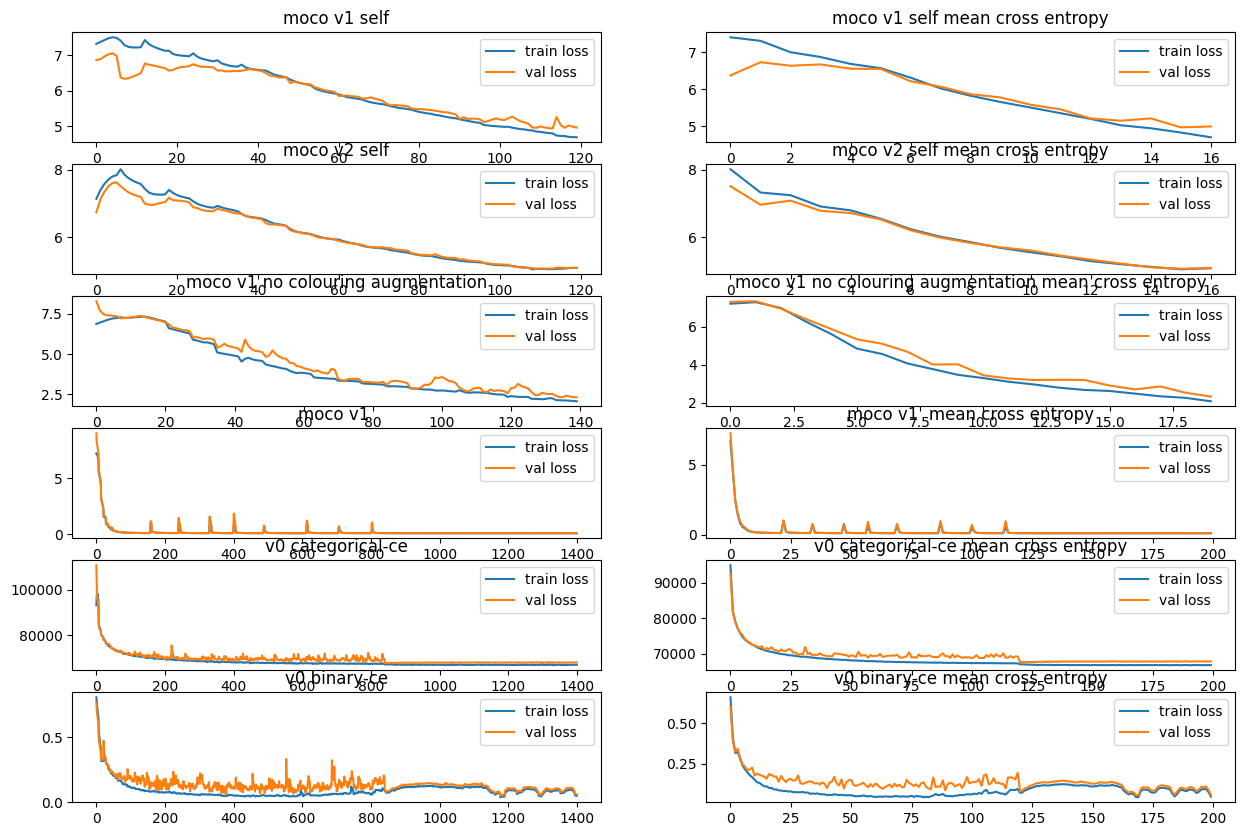

In [19]:
def extract_float(file_name, start="Epoch"):
  def isfloat(word):
    try:
      float(word)
      return True
    except ValueError:
      return False
  file = open(file_name)
  l = [[float(word) for word in re.split("\n|,| |\t|\(|\)", line) if isfloat(word)] for line in file if line.startswith(start)]
  return torch.tensor(l)

# general propose plot
file_names = [
  "./epochs20_batch128_lr0.03_momentum0.9_loss-typeself_V2False.txt",
  "./epochs20_batch128_lr0.03_momentum0.9_loss-typeself_V2True.txt", 
  "./epochs20_batch128_lr0.03_momentum0.9_loss-typeself_no-colouring.txt", 
  "./epochs200_batch128_lr0.03_momentum0.9_multi-typeself.txt", 
  "./epochs200_batch128_lr0.03_momentum0.9_multi-typecate-ce.txt", 
  "./epochs200_batch128_lr0.03_momentum0.9_loss-typebinary-ce.txt", 
  
]
fig, axarr = plt.subplots(len(file_names), 2, figsize=(15, 10))
names = ["moco v1 self", "moco v2 self", "moco v1 no colouring augmentation", "moco v1 ", "v0 categorical-ce", "v0 binary-ce"] # titles for each row of image, substitute of file name 
for i, file_name in enumerate(file_names):
  losses = extract_float(file_name) # shape [iteration_number * print num per iteration, 8], only loss at index [5, 7] are useful for plot
  train_index = {} # additional plot other than losses
  val_index = {}
  mean_loss_index = [i * 7 + 6 for i in range(losses.shape[0] // 7)]

  for j, idx in enumerate(train_index):
    axarr[i, j+1].plot(losses[:, idx])
  
  for j, idx in enumerate(val_index):
    axarr[i, j+1].plot(losses[:, idx])
    axarr[i, j+1].set_title(train_index[idx])

  axarr[i, 0].plot(losses[:, 5], label="train loss")
  axarr[i, 0].plot(losses[:, 7], label="val loss")
  axarr[i, 0].set_title(names[i])
  axarr[i, 0].legend(loc="upper right")


  axarr[i, -1].plot(losses[mean_loss_index, 5], label="train loss")
  axarr[i, -1].plot(losses[mean_loss_index, 7], label="val loss")
  axarr[i, -1].set_title(names[i] + " mean cross entropy")
  axarr[i, -1].legend(loc="upper right")


In [12]:
test_data = medmnist.PathMNIST("test", download=False, root=args.data, 
                                  #  transform=loader.TwoCropsTransform(transforms.Compose(augmentation)))
                                 transform=transforms.Compose([
                                  transforms.RandomResizedCrop(224, scale=(0.2, 1.)),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                ]))

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=512, shuffle=True, drop_last=True)
for x, y in test_loader:
  break

plot_test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x, y), batch_size=512)
# plot_test_loader = torch.utils.data.DataLoader(test_data, batch_size=16)

evaluating epochs20_batch128_lr0.03_momentum0.9_loss-typeself_V2True


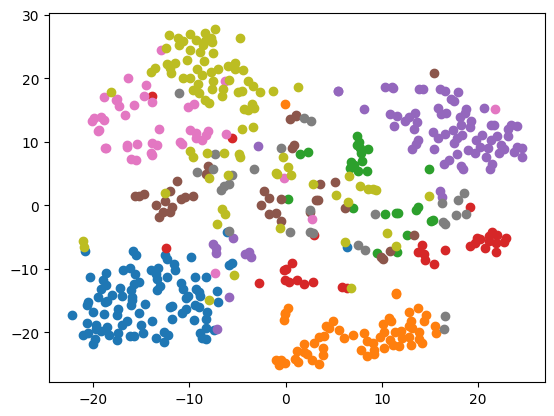

In [17]:
eval_name = "epochs20_batch128_lr0.03_momentum0.9_loss-typeself_V2True"
model = torch.load(ROOT + f"/moco/{eval_name}.pickle", map_location=torch.device('cpu') )
model.eval()
with torch.no_grad():
  embedding, _ = model(x, x, train=False)
z_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=30).fit_transform(embedding)

cs = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
print(f"evaluating f{eval_name}")
for i in range(0, y.max()+1):
  plt.scatter(z_embedded[(y == i).squeeze(), 0], z_embedded[(y == i).squeeze(), 1], c=cs[i])


evaluating fepochs20_batch128_lr0.03_momentum0.9_loss-typeself_V2False


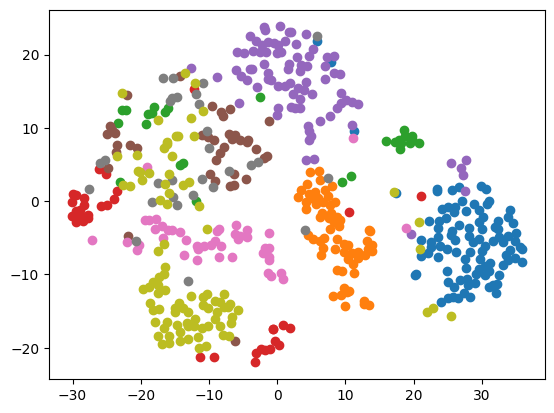

In [20]:
eval_name = "epochs20_batch128_lr0.03_momentum0.9_loss-typeself_V2False"
model = torch.load(ROOT + f"/moco/{eval_name}.pickle", map_location=torch.device('cpu') )
model.eval()
with torch.no_grad():
  embedding, _ = model(x, x, train=False)
z_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=30).fit_transform(embedding)

cs = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
print(f"evaluating f{eval_name}")
for i in range(0, y.max()+1):
  plt.scatter(z_embedded[(y == i).squeeze(), 0], z_embedded[(y == i).squeeze(), 1], c=cs[i])


In [ ]:
x = torch.randn((2,3))
y = torch.tensor([[1,0,1],[0, 1, 0]], dtype=torch.float32)

((x.exp() / x.exp().sum(dim=-1, keepdim=True)).log() * y).sum(dim=-1).mean(), nn.CrossEntropyLoss(reduction="mean")(x, y)

(tensor(-2.5201), tensor(2.5201))

In [ ]:
x = torch.randn((2,3))
y = torch.tensor([[1,0,1],[0, 1, 0]], dtype=torch.float32)
l = nn.BCEWithLogitsLoss()
sig = (1 / (1 + (-x).exp()))

(-(1 - y) * (1 - sig).log() - y * sig.log()).mean(), nn.functional.binary_cross_entropy_with_logits(x, y)

(tensor(0.9606), tensor(0.9606))